# NOTE: Make sure to change Runtime to GPU or TPU and upload `training_data.json`

# Recommendation system


- We have a employees_skills, projects and assignment_history matrix

- We will use the two tower approach to generate embeddings for users

In [1]:
# # If on CPU
# !pip install fastembed

# If on GPU
!pip install fastembed-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


## Imports

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Dot, Add
from keras.models import Model

from sklearn.model_selection import train_test_split
from fastembed import TextEmbedding
from typing import Optional, Dict, Any


## Loading Dataset

In [4]:

import json

# Opening JSON file
f = open('/content/training_data.json')

# returns JSON object as a dictionary
dataset_dict = json.load(f)
dataset_dict

{'users': {'employee_15429': {'skills': [{'skill_name': 'Python',
     'level': 'Professional',
     'months': 24},
    {'skill_name': 'Git', 'level': 'Basic', 'months': 6},
    {'skill_name': 'MongoDB', 'level': 'Basic', 'months': 6},
    {'skill_name': 'SQL', 'level': 'Basic', 'months': 6},
    {'skill_name': 'Docker', 'level': 'Basic', 'months': 6},
    {'skill_name': 'Excel', 'level': 'Basic', 'months': 6},
    {'skill_name': 'Javascript', 'level': 'Basic', 'months': 6},
    {'skill_name': 'Cloud Platform', 'level': 'Other', 'months': 12}],
   'description': "Acquisitions - Systems Engineer II Acquisitions - Systems Engineer II Carrollton, TX Expertise includes being an energetic professional with the ability to lead and motivate others. With over 20 years\x92 experience in Information Technology, telecommunications, and training, Skills include developing and documenting training procedures for departmental processes. Work Experience Acquisitions - Systems Engineer II Service Expe

## Dataset Loader

In [5]:
# ----------------------------
# Define categories and mappings
# ----------------------------
SKILL_CATEGORIES = [
    "Python",
    "AI and Machine learning",
    "Git",
    "MongoDB",
    "SQL",
    "Docker",
    "Excel",
    "Javascript",
    "Cloud Platform",
]
LEVEL_WEIGHT = {"Basic": 1.0, "CollegeResearch": 2.0, "Professional": 3.0, "Other": 1.5}

skill2idx = {s: i for i, s in enumerate(SKILL_CATEGORIES)}
# TEXT_EMB_MODEL = TextEmbedding()
TEXT_EMB_MODEL = TextEmbedding(providers=["CUDAExecutionProvider"])


class RecommendationDataset:
    def __init__(
        self,
        data: Optional[Dict[str, Any]] = None,
        n_users: int = 1000,
        n_projects: int = 500,
        interactions_per_user: int = 20,
        test_size: float = 0.2,
        random_state: int = 42
    ):
        """
        If `data` is provided, it should be a dict with keys:
          - 'users': {user_id: {skills: [...], description: str}, ...}
          - 'projects': {project_id: {skills: [...], description: str}, ...}
          - 'interactions': [{user_id, project_id, rating}, ...]
        Otherwise synthetic data is generated.
        """
        self.test_size = test_size
        self.random_state = random_state
        np.random.seed(self.random_state)

        # placeholders
        self.user_profiles = None
        self.project_profiles = None
        self.user_text_embs = None
        self.project_text_embs = None
        self.interactions = None
        self.train = None
        self.val = None

        if data is not None:
            self._load_from_data(data)
            print('generating from provided dict')

        else:
            print('generating synthethic data instead')
            self.n_users = n_users
            self.n_projects = n_projects
            self.k = interactions_per_user
            self._generate_synthetic()
        self._split()

    def _load_from_data(self, data: Dict[str, Any]):
        users = list(data['users'].keys())
        projects = list(data['projects'].keys())
        self.n_users = len(users)
        self.n_projects = len(projects)
        user2idx = {u:i for i,u in enumerate(users)}
        proj2idx = {p:i for i,p in enumerate(projects)}

        # build numeric profiles
        def vec_from_skills(sk):
            v = np.zeros(len(SKILL_CATEGORIES), dtype=float)
            for s in sk:
                idx = skill2idx[s['skill_name']]
                v[idx] = LEVEL_WEIGHT[s['level']] * s['months']
            return v

        self.user_profiles = np.vstack([
            vec_from_skills(data['users'][u]['skills']) for u in users
        ])
        self.project_profiles = np.vstack([
            vec_from_skills(data['projects'][p]['skills']) for p in projects
        ])

        # Scale values while keeping the magnitude
        epsilon = 1e-8
        self.user_profiles = self.user_profiles / (np.linalg.norm(self.user_profiles, axis=1, keepdims=True) + epsilon)
        self.project_profiles = self.project_profiles / (np.linalg.norm(self.project_profiles, axis=1, keepdims=True) + epsilon)


        # build text embeddings
        user_texts = [data['users'][u]['description'] for u in users]
        proj_texts = [data['projects'][p]['description'] for p in projects]
        self.user_text_embs = np.vstack(list(TEXT_EMB_MODEL.embed(user_texts)))
        self.project_text_embs = np.vstack(list(TEXT_EMB_MODEL.embed(proj_texts)))

        # build interactions DataFrame
        df = pd.DataFrame(data['interactions'])
        df['user_idx'] = df['user_id'].map(user2idx)
        df['project_idx'] = df['project_id'].map(proj2idx)
        self.interactions = df[['user_idx','project_idx','rating']]

    def _generate_synthetic(self):
        # reuse previous synthetic generation
        users, projs, user_texts, proj_texts = [], [], [], []
        sample_texts = [
            "Analysis of time-series financial data.",
            "Image recognition using convolutional neural networks.",
            "Design and deploy RESTful APIs.",
            "Database schema optimization and indexing.",
            "Data visualization dashboard development."
        ]
        # users
        for _ in range(self.n_users):
            n_sk = np.random.randint(1, len(SKILL_CATEGORIES)+1)
            chosen = np.random.choice(SKILL_CATEGORIES, size=n_sk, replace=False)
            vec = np.zeros(len(SKILL_CATEGORIES))
            for skill in chosen:
                lvl = np.random.choice(list(LEVEL_WEIGHT.keys()))
                months = np.random.randint(1,36)
                vec[skill2idx[skill]] = LEVEL_WEIGHT[lvl]*months
            users.append(vec)
            user_texts.append(np.random.choice(sample_texts))
        # projects
        for _ in range(self.n_projects):
            n_sk = np.random.randint(1, len(SKILL_CATEGORIES)+1)
            chosen = np.random.choice(SKILL_CATEGORIES, size=n_sk, replace=False)
            vec = np.zeros(len(SKILL_CATEGORIES))
            for skill in chosen:
                lvl = np.random.choice(list(LEVEL_WEIGHT.keys()))
                imp = np.random.uniform(0.5,1.5)
                vec[skill2idx[skill]] = LEVEL_WEIGHT[lvl]*imp
            projs.append(vec)
            proj_texts.append(np.random.choice(sample_texts))

        self.user_profiles = np.vstack(users)
        self.project_profiles = np.vstack(projs)

        # Scale values while keeping the magnitude
        self.user_profiles = self.user_profiles / np.linalg.norm(self.user_profiles, axis=1, keepdims=True)
        self.project_profiles = self.project_profiles / np.linalg.norm(self.project_profiles, axis=1, keepdims=True)

        self.user_text_embs = np.vstack(list(TEXT_EMB_MODEL.embed(user_texts)))
        self.project_text_embs = np.vstack(list(TEXT_EMB_MODEL.embed(proj_texts)))

        # synthetic interactions
        rows = []
        u_norm = self.user_profiles/np.linalg.norm(self.user_profiles,axis=1,keepdims=True)
        p_norm = self.project_profiles/np.linalg.norm(self.project_profiles,axis=1,keepdims=True)
        for u in range(self.n_users):
            candidates = np.random.choice(self.n_projects, size=self.k, replace=False)
            for p in candidates:
                score = u_norm[u].dot(p_norm[p])
                rows.append((u,p, 1+4*score))
        self.interactions = pd.DataFrame(rows, columns=['user_idx','project_idx','rating'])

    def _split(self):
        train, val = train_test_split(
            self.interactions,
            test_size=self.test_size,
            random_state=self.random_state
        )
        self.train = train.reset_index(drop=True)
        self.val = val.reset_index(drop=True)



dataset = RecommendationDataset(data=dataset_dict, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

generating from provided dict


In [17]:
import keras
from keras import ops
from keras import layers
from keras import Model

# Modular Tower Block
@keras.saving.register_keras_serializable()
class Tower(keras.Model):
    def __init__(self, emb_size: int = 32, name: str = "tower", **kwargs):
        super().__init__(name=name, **kwargs)
        self.emb_size = emb_size  # Store for get_config
        self.dense_num = layers.Dense(emb_size, activation='relu', name=f"{name}_dense_num")
        self.dense_txt = layers.Dense(emb_size, activation='relu', name=f"{name}_dense_txt")
        self.add = layers.Add(name=f"{name}_add")

    def call(self, inputs):
        num_input, txt_input = inputs
        emb_num = self.dense_num(num_input)
        emb_txt = self.dense_txt(txt_input)
        return self.add([emb_num, emb_txt])

    def get_config(self):
        config = super().get_config()
        config.update({
            "emb_size": self.emb_size,
        })
        return config

# Full Two-Tower Model
@keras.saving.register_keras_serializable()
class TwoTowerModel(keras.Model):
    def __init__(self, emb_size: int = 32, **kwargs):
        super().__init__(**kwargs)
        self.emb_size = emb_size  # Store for get_config
        self.user_tower = Tower(emb_size, name="user_tower")
        self.proj_tower = Tower(emb_size, name="proj_tower")
        self.dot = layers.Dot(axes=1, name="dot_similarity")

    def call(self, inputs):
        u_num, u_txt, p_num, p_txt = inputs
        u_emb = self.user_tower([u_num, u_txt])
        p_emb = self.proj_tower([p_num, p_txt])
        return self.dot([u_emb, p_emb])

    def get_config(self):
        config = super().get_config()
        config.update({
            "emb_size": self.emb_size,
        })
        return config

# Instantiate model
def build_model(n_skills: int, text_emb_size: int, emb_size: int = 32):
    # Keras 3-style Input
    u_num = keras.Input(shape=(n_skills,), name='user_num')
    u_txt = keras.Input(shape=(text_emb_size,), name='user_txt')
    p_num = keras.Input(shape=(n_skills,), name='proj_num')
    p_txt = keras.Input(shape=(text_emb_size,), name='proj_txt')

    two_tower = TwoTowerModel(emb_size=emb_size)
    output = two_tower([u_num, u_txt, p_num, p_txt])

    model = keras.Model(inputs=[u_num, u_txt, p_num, p_txt], outputs=output, name="TwoTowerModel")
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [24]:
EPOCHS = 400
BATCH_SIZE=256

TEXT_EMB_SIZE = 384  # fixed output dimension
EMB_SIZE=32

DEPTH = 3
DROPOUT_RATE = 0.2
model_4 = build_model(len(SKILL_CATEGORIES), TEXT_EMB_SIZE, emb_size=EMB_SIZE)

# model = build_model(n_skills=len(SKILL_CATEGORIES), text_emb_size=TEXT_EMB_SIZE, emb_size=EMB_SIZE, depth=DEPTH, dropout_rate=DROPOUT_RATE)


In [25]:
history = model_4.fit(
    x=[dataset.user_profiles[dataset.train.user_idx],
       dataset.user_text_embs[dataset.train.user_idx],
       dataset.project_profiles[dataset.train.project_idx],
       dataset.project_text_embs[dataset.train.project_idx]],
    y=dataset.train.rating.values,
    validation_data=(
       [dataset.user_profiles[dataset.val.user_idx],
        dataset.user_text_embs[dataset.val.user_idx],
        dataset.project_profiles[dataset.val.project_idx],
        dataset.project_text_embs[dataset.val.project_idx]],
       dataset.val.rating.values
    ),
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

Epoch 1/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 2/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 3/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 4/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 5/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 6/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 7/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 8/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 9/400
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.03

## Training Plots

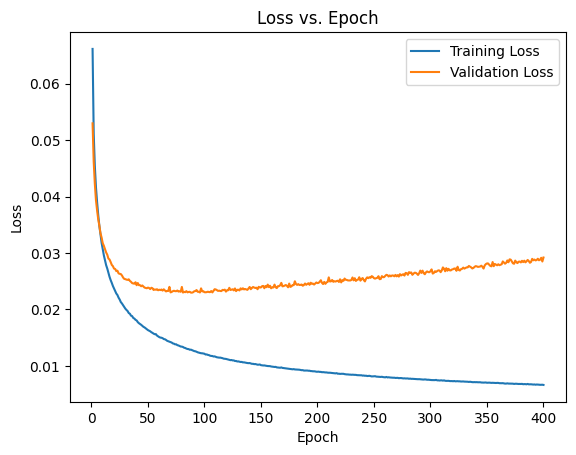

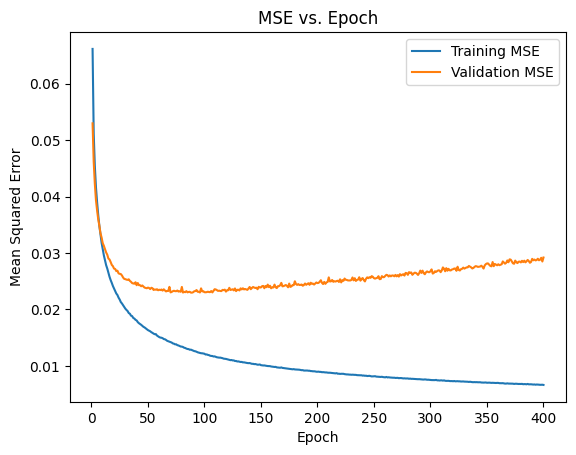

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


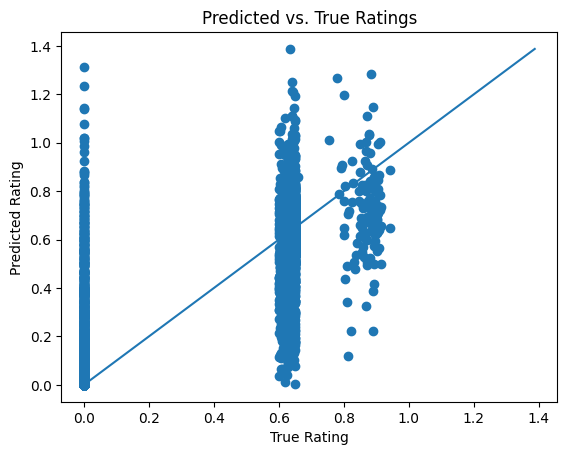

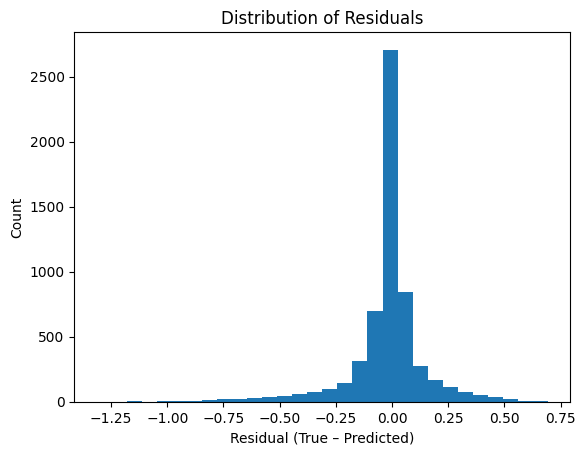

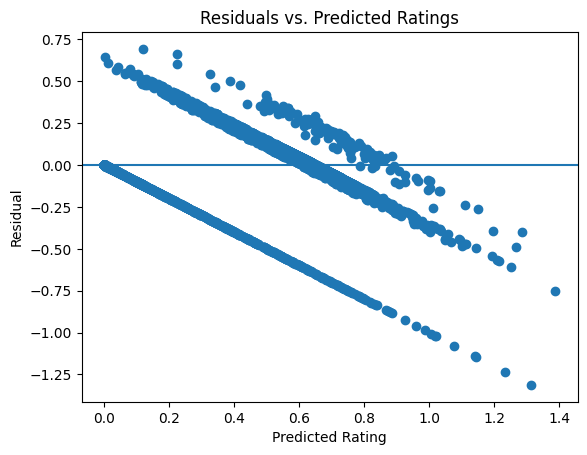

Validation MAE: 0.0952
Validation RMSE: 0.1709


In [26]:
import matplotlib.pyplot as plt
import numpy as np

loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history.get('mse', [])
val_mse = history.history.get('val_mse', [])
epochs = range(1, len(loss) + 1)

# 1) Loss vs. Epoch
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) MSE vs. Epoch
plt.figure()
plt.plot(epochs, mse, label='Training MSE')
plt.plot(epochs, val_mse, label='Validation MSE')
plt.title('MSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Prepare validation data
y_true = dataset.val.rating.values
y_pred = model_4.predict([
    dataset.user_profiles[dataset.val.user_idx],
    dataset.user_text_embs[dataset.val.user_idx],
    dataset.project_profiles[dataset.val.project_idx],
    dataset.project_text_embs[dataset.val.project_idx]
]).flatten()

# 3) Predicted vs. True Ratings
plt.figure()
plt.scatter(y_true, y_pred)
minv, maxv = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv])
plt.title('Predicted vs. True Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

# 4) Residuals Distribution
residuals = y_true - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (True – Predicted)')
plt.ylabel('Count')
plt.show()

# 5) Residuals vs. Predicted
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.title('Residuals vs. Predicted Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('Residual')
plt.show()

# Compute additional metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
print(f'Validation MAE: {mae:.4f}')
print(f'Validation RMSE: {rmse:.4f}')


## Evaluation Plots

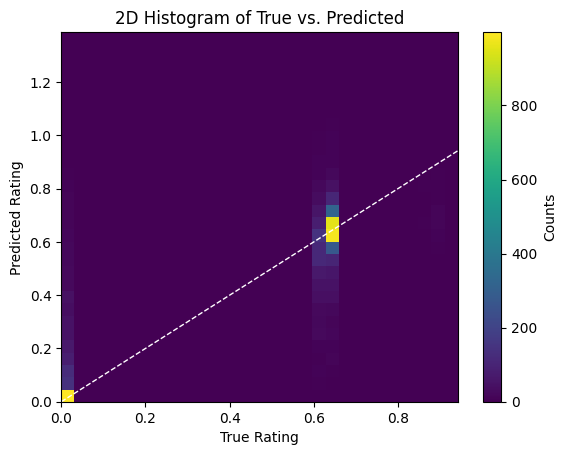

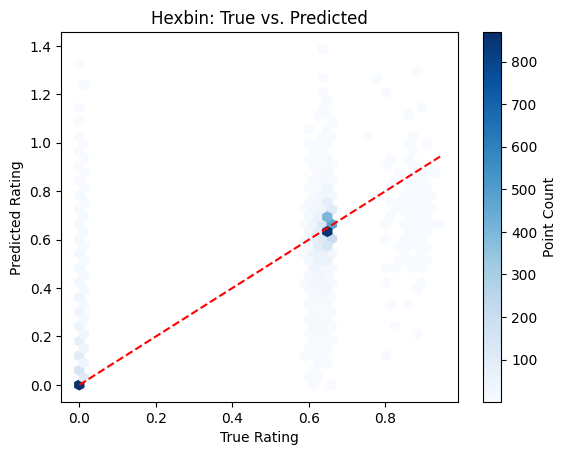

In [27]:
# 2d histogram
import numpy as np
import matplotlib.pyplot as plt

# y_true, y_pred from your validation set
bins = 30
heatmap, xedges, yedges = np.histogram2d(y_true, y_pred, bins=bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.plot([extent[0], extent[1]], [extent[0], extent[1]], 'w--', linewidth=1)  # diagonal
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('2D Histogram of True vs. Predicted')
plt.colorbar(label='Counts')
plt.show()


# Hexbin Scatter
plt.figure()
plt.hexbin(y_true, y_pred, gridsize=40, cmap='Blues', mincnt=1)
plt.plot([extent[0], extent[1]], [extent[0], extent[1]], 'r--')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Hexbin: True vs. Predicted')
plt.colorbar(label='Point Count')
plt.show()

## Dump Trained models and Embedding

In [28]:
# 2) Dump trained model and project data arrays
model_4.save("two_tower_model.keras")
np.save("project_profiles.npy", dataset.project_profiles)
np.save("project_text_embs.npy", dataset.project_text_embs)
print("Saved model -> two_tower_model.h5")
print("Saved profiles -> project_profiles.npy, project_text_embs.npy")



Saved model -> two_tower_model.h5
Saved profiles -> project_profiles.npy, project_text_embs.npy


## Standalone Service class

In [30]:

import numpy as np
import tensorflow as tf
from fastembed import TextEmbedding
from typing import List, Dict, Tuple, Any

# ----------------------------
# (Re) Define categories and mappings
# ----------------------------
SKILL_CATEGORIES = [
    "Python",
    "AI and Machine learning",
    "Git",
    "MongoDB",
    "SQL",
    "Docker",
    "Excel",
    "Javascript",
    "Cloud Platform",
]
LEVEL_WEIGHT = {"Basic": 1.0, "CollegeResearch": 2.0, "Professional": 3.0, "Other": 1.5}


skill2idx: Dict[str, int] = {s: i for i, s in enumerate(SKILL_CATEGORIES)}

class RecommendationService:
    def __init__(
        self,
        model_path: str,
        project_profiles_path: str,
        project_text_embs_path: str
    ):
        """
        Initializes the service by loading a Keras model and data arrays.

        :param model_path: Path to saved Keras .h5 model
        :param project_profiles_path: Path to .npy numeric profiles array
        :param project_text_embs_path: Path to .npy text embeddings array
        """
        # Load the trained model for inference (skip compile to avoid custom metric errors)
        self.model = keras.saving.load_model(model_path, compile=False)

        self.project_profiles = np.load(project_profiles_path)
        self.project_text_embs = np.load(project_text_embs_path)
        self.text_model = TextEmbedding()
        self.n_projects = self.project_profiles.shape[0]

    def build_user_vector(self, skills: List[Dict[str, Any]]) -> np.ndarray:
        """Convert skill dicts into a numeric feature vector."""
        vec = np.zeros(len(SKILL_CATEGORIES), dtype=float)
        for s in skills:
            name = s['skill_name']; level = s['level']; months = s['months']
            if name not in skill2idx or level not in LEVEL_WEIGHT:
                raise ValueError(f"Invalid skill entry: {s}")
            vec[skill2idx[name]] = months * LEVEL_WEIGHT[level]
        return vec

    def embed_text(self, text: str) -> np.ndarray:
        """Generate a text embedding vector."""
        emb_gen = self.text_model.embed([text])
        return np.vstack(list(emb_gen))[0]

    def recommend(
        self,
        skills: List[Dict[str, Any]],
        description: str,
        top_k: int = 5
    ) -> Tuple[List[int], List[float]]:
        """Return top-K project indices and match scores."""
        user_num = self.build_user_vector(skills)
        user_txt = self.embed_text(description)
        num_tile = np.tile(user_num, (self.n_projects, 1))
        txt_tile = np.tile(user_txt, (self.n_projects, 1))

        # For inference, compile=False model can still run predict
        preds = self.model.predict([
            num_tile,
            txt_tile,
            self.project_profiles,
            self.project_text_embs
        ], verbose=0).flatten()
        idxs = np.argsort(preds)[-top_k:][::-1]
        return idxs.tolist(), preds[idxs].tolist()



In [31]:
service = RecommendationService(
    model_path="two_tower_model.keras",
    project_profiles_path="project_profiles.npy",
    project_text_embs_path="project_text_embs.npy"
)

skills = [
    {"skill_name": "Javascript", "level": "Basic", "months": 10},
]
description = "Basic Javascript developer"

top_projects, scores = service.recommend(skills, description, top_k=10)

print("Recommended project indices:", top_projects)
print("Match scores:", scores)

Recommended project indices: [312, 107, 127, 253, 275, 426, 430, 158, 260, 283]
Match scores: [12.373818397521973, 11.198912620544434, 10.707904815673828, 10.263721466064453, 10.119784355163574, 10.118452072143555, 10.072047233581543, 9.345756530761719, 9.277349472045898, 9.275938034057617]


In [32]:
# Map array indices back to your real project IDs
projects = list(dataset_dict['projects'].keys())
proj2idx = {pid: i for i, pid in enumerate(projects)}
idx2proj = {i: pid for pid, i in proj2idx.items()}

recommended_ids = [idx2proj[i] for i in top_projects]
print(recommended_ids)
# ANSI color codes (no external libs needed)
colors = [
    "\033[95m",  # magenta
    "\033[94m",  # blue
    "\033[96m",  # cyan
    "\033[92m",  # green
    "\033[93m",  # yellow
    "\033[91m",  # red
]
RESET = "\033[0m"

# Pretty-print each recommendation with rank, score, description, and skills
for rank, (pid, score) in enumerate(zip(recommended_ids, scores), start=1):
    project = dataset_dict['projects'][pid]
    desc = project.get("description", "No description available.")
    skills = project.get("skills", [])

    color = colors[(rank - 1) % len(colors)]
    print(f"{color}Rank {rank}: {pid}  |  Score: {score:.2f}{RESET}")
    print(f"{color}Description:{RESET} {desc}")
    print(f"{color}Required Skills:{RESET}")
    for s in skills:
        name = s.get("skill_name", "Unknown")
        level = s.get("level", "Unknown")
        months = s.get("months", 0)
        print(f"  - {name} ({level}, {months} months)")
    print()  # blank line between entries


['project_703', 'project_211', 'project_265', 'project_558', 'project_607', 'project_936', 'project_941', 'project_341', 'project_574', 'project_626']
Rank 1: project_703  |  Score: 12.37
Description: **Title:** Headhunting Specialist: Job Description   Send me Jobs like this Duties and Responsibilities: Exp :5+ years ( IT) Non-IT recruiter(preferably Healthcare domain) Strategically utilize job boards, networks, forums, blogs and research methods to source passive candidates Handle multiple requisitions Maintain high quality/maximum traction for hiring Innovate in sourcing strategies Create job descriptions Understand and extract information from job descriptions Employ the most appropriate recruitment channel to source candidates Schedule interviews Follow-up with the candidates Develop a pool of qualified candidates in advance of need. Salary: Not Disclosed by Recruiter Industry: Recruitment / Staffing Functional Area: HR , Recruitment , Administration , IR Role Category:HR/ Recruit